In [1]:
library(randomForest)
library(glmnet)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.

Loading required package: Matrix

Loaded glmnet 4.1-6



In [1]:
wH=read.csv("../data/jasa_10_07_2023_data/weatherHistory.csv")
wH[1:4,]
dim(wH)

,Formatted.Date,Summary,Precip.Type,Temperature..C.,Apparent.Temperature..C.,Humidity,Wind.Speed..km.h.,Wind.Bearing..degrees.,Visibility..km.,Loud.Cover,Pressure..millibars.,Daily.Summary
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251,15.8263,0,1015.13,Partly cloudy throughout the day.
2,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259,15.8263,0,1015.63,Partly cloudy throughout the day.
3,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204,14.9569,0,1015.94,Partly cloudy throughout the day.
4,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269,15.8263,0,1016.41,Partly cloudy throughout the day.


[1] 96453    12

In [3]:
 X=wH[,c(6,7,9,11)]
 Yfull=wH[,4]
# tX=bike[-ind,c(6,8,10,12,13)]
s1=sample(1:nrow(X),30000,replace=FALSE)
tX=X[-s1,]
X=X[s1,]
Ye=Yfull[s1]

nfull=nrow(X)

In [4]:
#with random forest
reps=1:15
rho=seq(0,2,0.2)
MC=matrix(0,nrow=ncol(X),ncol=length(rho))
MC_n=matrix(0,nrow=ncol(X),ncol=length(rho))

RS1=matrix(0,nrow=ncol(X),ncol=length(rho))
RS2=matrix(0,nrow=ncol(X),ncol=length(rho))


trsize=20000
tesize=5000

for(rep in reps)
    {
sn1=sample(1:nrow(X),trsize+tesize,replace=FALSE)
sam1=sn1[1:trsize]
Xtr=X[sam1,]
Y=Ye[sam1]
tr=as.data.frame(cbind(Y,Xtr))

sam2=sn1[(trsize+1):(trsize+tesize)]
Xte=X[sam2,]
Y=Ye[sam2]
te=as.data.frame(cbind(Y,Xte))

size=tesize
split=5
K=size/split

fit=lm(Y~.,tr)
yh=predict(fit,te)
S=abs(yh-te[,1])
Q_90=quantile(S[1:K],0.9)

Ste=S[(K+1):size]
indic=as.factor(as.numeric(Ste>Q_90))
# Xte=te[(K+1):size,2:5]
ten=te[(K+1):size,]

Xval=X[-sn1,]
Yval=Ye[-sn1]
val=as.data.frame(cbind(Yval,Xval))
    
sens_rho=matrix(0,nrow=split-1,ncol=length(rho))

k=1

Var=2:(ncol(tr))
for(var in Var)
    {
for(i in 0:(split-2))
    {
    
    index=1:(size-K)
    index1=index[-(((K*i)+1):(K*(i+1)))]
    index2=index[(((K*i)+1):(K*(i+1)))]
 newtr=as.data.frame(cbind(as.factor(indic[index1]),ten[index1,var]))
 colnames(newtr)=c("I","V1")

    
    pf=randomForest(as.factor(I)~.,newtr,ntree=100,nodesize=50,importance=TRUE,
                        proximity=TRUE)
    

    
     xxx=as.data.frame(cbind(ten[index2,var],ten[index2,var]^2))
 
    colnames(xxx)=c("V1","X12")
    p2=predict(pf, xxx, type = "prob")[,2]

#       xxx=as.data.frame(cbind(tX[,var-1],tX[,var-1]^2))
#       colnames(xxx)=c("V1","X12")
#      etap=predict(pf, xxx, type = "prob")[,2]
    

    k=1
    for(r in rho)
    {
    
#      eta=quantile(etap,1-exp(-r))
    
       eta=quantile(p2,1-exp(-r))
     d1=p2-eta
#     pindf=which(d1>0)
#     d2=mean(p2[pindf])
    d1=d1*(d1>0)
    d2=exp(r)*d1+eta
    d3=exp(r)*(as.numeric(p2>eta))*(as.numeric(indic[index2])-1-p2)

        sens_rho[(i+1),k]=mean(d2)+mean(d3)
        

        
       k=k+1
    
    
    
}
 
    }
    
       sens=colMeans(sens_rho)
    
   
    MCM=sens
    MCM=MCM-MCM[1]+0.1
    
    
    MC[var-1,]=MC[var-1,]+MCM
    
    sens_rho=matrix(0,nrow=split-1,ncol=length(rho))

    
        m=1
for(r in rho)
    {
      X_i=ten[,var]
    q1=quantile(X_i,1-exp(-r))
    q2=-quantile(-X_i,1-exp(-r))
    
    ind1=which(X_i>q1)
    ind2=which(X_i<=q2)
    
    indic1=(as.numeric(Ste[ind1]>Q_90))
    
    indic2=(as.numeric(Ste[ind2]>Q_90))
    
    RS1[var-1,m]=RS1[var-1,m]+mean(indic1)
#     RS1[var-1,k]=RS1[var-1,k]-RS1[var-1,1]+0.1
    
    RS2[var-1,m]=RS2[var-1,m]+mean(indic2)
#     RS2[var-1,k]=RS2[var-1,k]-RS2[var-1,1]+0.1
    m=m+1
    
    }
    
    
    }
}
MC=MC/length(reps)

RS1=RS1/length(reps)
RS2=RS2/length(reps)

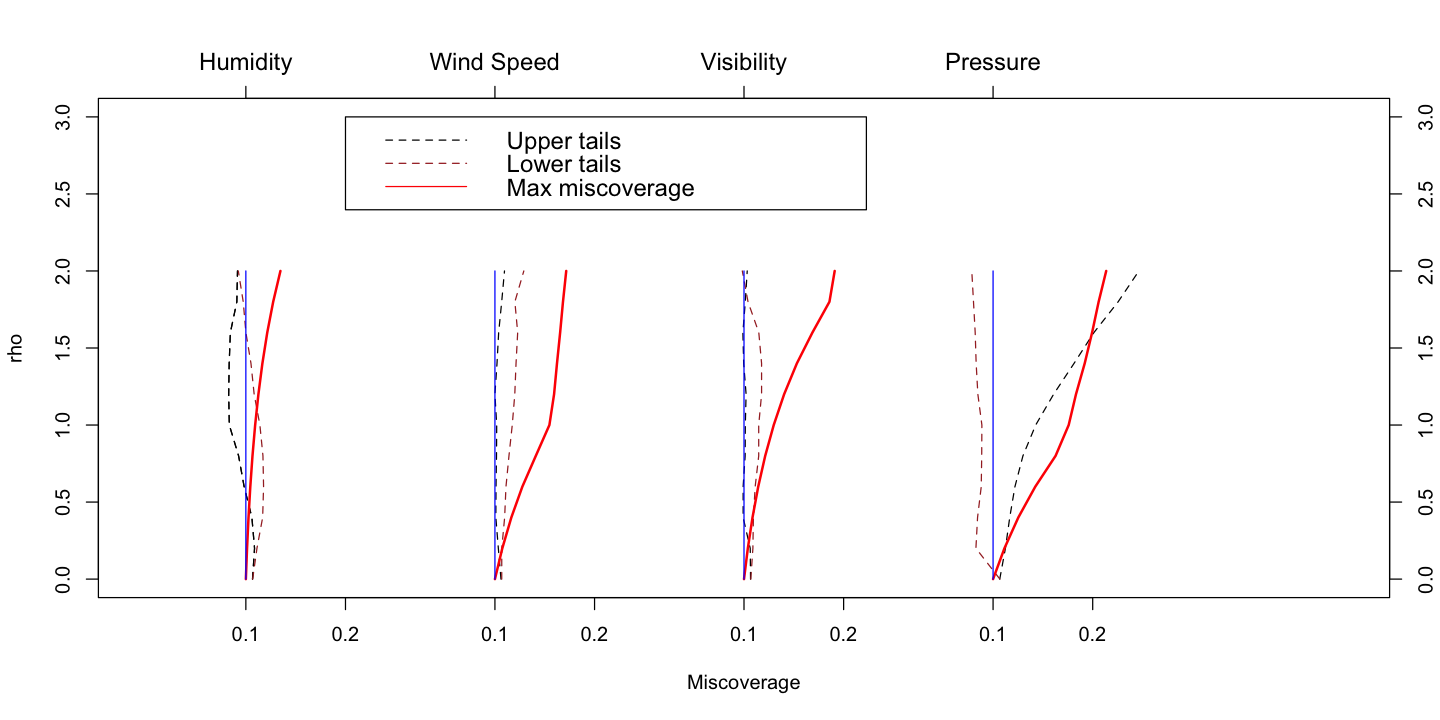

In [5]:
options(repr.plot.width=12, repr.plot.height=6)

inc=0.25
gh=1
thick_up_lo=2
type_of_rs=2

plot(RS1[gh,],rho,xlim=c(0,1.2),ylim=c(0,3),cex.axis=1,xaxt = "n",xlab="Miscoverage",lty=type_of_rs,ty='l')
att=c(0.1,0.2,0.1+inc,0.2+inc,0.1+2*inc,0.2+2*inc,0.1+3*inc,0.2+3*inc)
axis(side=1, at=att, cex.axis=1,labels=c(.1,.2,.1,.2,.1,.2,0.1,.2))



for(gh in 1:length(Var))
    {
    lines(RS1[gh,]+(gh-1)*inc,rho,lty=type_of_rs,ty='l')
lines(RS2[gh,]+(gh-1)*inc,rho,ty='l',lty=type_of_rs,col="brown")
lines(MC[gh,]+(gh-1)*inc,rho,ty='l',lwd=thick_up_lo,col="red")
    lines(c(0.1+(gh-1)*inc,0.1+(gh-1)*inc),c(0,2),ty='l',col="blue")
}
att=c(0.1,0.1+inc,0.1+2*inc,0.1+3*inc)
# axis(1, at=att, labels=c("Humidity","Wind Speed","Visibility","Pressure"))
axis(side=4,cex.axis=1)
axis(side=3, at=att,las=1, cex.lab=1.2,cex.axis=1.2, font=0.5,xlab="Variables", labels=c("Humidity","Wind Speed","Visibility","Pressure"))

legend(0.2,3, legend=c("Upper tails", "Lower tails","Max miscoverage"),
       col=c("black", "brown","red","red"), lty=c(2,2,1,1), cex=1.2)

In [24]:
write.csv(MC,"MC_new.csv")

write.csv(RS1,"RS1_new.csv")
write.csv(RS2,"RS2_new.csv")